<a href="https://colab.research.google.com/github/srinivas2234/DonorsChooseDataset/blob/main/NB_Assignment_Srinivas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from sklearn.preprocessing import Normalizer #L2 norm
from sklearn.preprocessing import StandardScaler# z= (x-mean)/sigma

In [4]:
from scipy.sparse import hstack
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [5]:
import matplotlib.pyplot as plt

In [6]:
def vectorizer(df_train,df_test,name,vect):
    train = vect.fit_transform(df_train[name])
    test = vect.transform(df_test[name])
    return train,test,vect
def vecotizer2d(df_train,df_test,name,vect):
    train = vect.fit_transform(df_train[name].values.reshape(-1,1))
    test = vect.transform(df_test[name].values.reshape(-1,1))
    return train , test, vect
def plotAucAllHyperParameter(plot_data):
    x = [ s['alpha'] for s in plot_data['params']]
    y_test = plot_data['mean_test_score']
    y_train = plot_data['mean_train_score']
    plt.plot(x,y_train,label="Train",color='blue')
    plt.plot(x,y_test,label="Test",color='red')
    plt.xlabel("Hyper parameter alpha -->")
    plt.ylabel("ROC AUC -->")
    plt.legend()
    plt.show()

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cd /content/drive/MyDrive/Datasets/

/content/drive/MyDrive/Datasets


In [9]:
ls

5_a.csv  5_c.csv  preprocessed_data.csv  train_data.csv
5_b.csv  5_d.csv  resources.csv


In [25]:
project_data = pd.read_csv('preprocessed_data.csv')
project_data.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [37]:
project_data.shape
#project_data.columns

(109248, 9)

# **Splitting data into Train and cross validation(or test): Stratified Sampling**

In [27]:
k = list(project_data.columns.values)

In [28]:
import copy
X=copy.copy(project_data)

In [29]:
X.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [30]:
X.drop(['project_is_approved'], axis=1, inplace=True)
X.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [ ]:
y=project_data['project_is_approved']


In [34]:
# write your code in following steps for task 1
# 1. Split your data.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)
#as I will be performing randomsearchCV no validation set


**Featueizing essay BOW**

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
countvect=CountVectorizer(ngram_range=(1,2))
countvect.fit(X_train['essay'])
train_bow= countvect.transform(X_train['essay'])
test_bow= countvect.transform(X_test['essay'])
print(train_bow.shape,test_bow.shape )


(87398, 2266995) (21850, 2266995)


In [57]:
# 4. perform one-hot encoding of categorical features.
# 'school_state', 'teacher_prefix', 'project_grade_category','clean_categories','clean_subcategories'
train_state,test_state,model_state = vectorizer(X_train,X_test,'school_state',CountVectorizer(binary=True))
train_prefic, test_prefix,model_prefix = vectorizer(X_train,X_test,'teacher_prefix',CountVectorizer(binary=True))
train_grade, test_grade,model_grade = vectorizer(X_train,X_test,'project_grade_category',CountVectorizer(binary=True))
trian_cat, test_cat,model_cat = vectorizer(X_train,X_test,'clean_categories',CountVectorizer(binary=True))
train_sub, test_sub,model_sub = vectorizer(X_train,X_test,'clean_subcategories',CountVectorizer(binary=True))

In [58]:
# 5. perform normalization of numerical features
# price , teacher_number_of_previously_posted_projects

# We are not using standard scalar because 
train_price,test_price,model_price = vecotizer2d(X_train,X_test,'price',Normalizer())
train_prev_posted, test_prev_posted,model_prev_posted = vecotizer2d(X_train, X_test,'teacher_number_of_previously_posted_projects',Normalizer())

In [59]:
print(train_bow.shape,train_state.shape,train_prefic.shape,train_grade.shape,trian_cat.shape,train_sub.shape,train_price.shape,train_prev_posted.shape)


(87398, 2266995) (87398, 51) (87398, 5) (87398, 4) (87398, 9) (87398, 30) (87398, 1) (87398, 1)


**Featueizing essay TFIDF**

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvec=TfidfVectorizer(ngram_range=(1,2))
tfidfvec.fit(X_train['essay'])
tfidf_train_essay=tfidfvec.transform(X_train['essay'])
tfidf_test_essay=tfidfvec.transform(X_test['essay'])
print(tfidf_train_essay.shape, tfidf_test_essay.shape)

(87398, 2266995) (21850, 2266995)


# **Apply TF-IDF vectorization on 'Preprocessed_Title'**
**Make Data Model Ready: encoding numerical, categorical features**

In [47]:
tfidfvec.fit(X_train['school_state'])
tfidf_train_school_state=tfidfvec.transform(X_train['school_state'])
tfidf_test_school_state=tfidfvec.transform(X_test['school_state'])
print(tfidf_train_school_state.shape, tfidf_test_school_state.shape)

(87398, 51) (21850, 51)


In [48]:
tfidfvec.fit(X_train['teacher_prefix'])
tfidf_train_teacher_prefix=tfidfvec.transform(X_train['teacher_prefix'])
tfidf_test_teacher_prefix=tfidfvec.transform(X_test['teacher_prefix'])
print(tfidf_train_teacher_prefix.shape, tfidf_test_teacher_prefix.shape)

(87398, 5) (21850, 5)


In [49]:
tfidfvec.fit(X_train['project_grade_category'])
tfidf_train_project_grade_category=tfidfvec.transform(X_train['project_grade_category'])
tfidf_test_project_grade_category=tfidfvec.transform(X_test['project_grade_category'])
print(tfidf_train_project_grade_category.shape, tfidf_test_project_grade_category.shape)

(87398, 4) (21850, 4)


In [50]:
tfidfvec.fit(X_train['clean_categories'])
tfidf_train_clean_categories=tfidfvec.transform(X_train['clean_categories'])
tfidf_test_clean_categories=tfidfvec.transform(X_test['clean_categories'])
print(tfidf_train_clean_categories.shape, tfidf_test_clean_categories.shape)

(87398, 53) (21850, 53)


In [51]:
tfidfvec.fit(X_train['clean_subcategories'])
tfidf_train_clean_subcategories=tfidfvec.transform(X_train['clean_subcategories'])
tfidf_test_clean_subcategories=tfidfvec.transform(X_test['clean_subcategories'])
print(tfidf_train_clean_subcategories.shape, tfidf_test_clean_subcategories.shape)

(87398, 397) (21850, 397)


In [62]:
# 5. perform normalization of numerical features
# price , teacher_number_of_previously_posted_projects

# We are not using standard scalar because 
from sklearn.preprocessing import Normalizer
model_prev_posted=Normalizer()
train_prev_posted=model_prev_posted.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
train_prev_posted=model_prev_posted.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
test_prev_posted=model_prev_posted.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(train_prev_posted.shape, test_prev_posted.shape)


(87398, 1) (21850, 1)


**Constructing a single featue vector**

In [116]:
# 6. For set 1 stack up all the features using hstack()
train_set1 = hstack((train_bow,train_state,train_prefic,train_grade,trian_cat,train_sub,train_price,train_prev_posted))
test_set1 = hstack((test_bow,test_state,test_prefix,test_grade,test_cat,test_sub,test_price,test_prev_posted))
# 7. For set 2 stack up all the features using hstack()
train_set2= hstack((tfidf_train_essay,train_state,train_prefic,train_grade,trian_cat,train_sub,train_price,train_prev_posted))
test_set2 = hstack((tfidf_test_essay,test_state,test_prefix,test_grade,test_cat,test_sub,test_price,test_prev_posted))

In [117]:
print(type(train_set1),type(y_train))

<class 'scipy.sparse.coo.coo_matrix'> <class 'pandas.core.series.Series'>


# **Appling NB on different kind of featurization as mentioned in the instructions**
Apply NB on different kind of featurization as mentioned in the instructions
For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [66]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
hp_space = {'alpha':[0.01,0.05,0.1,0.2,0.5,1]}
mnb=MultinomialNB()
gs=GridSearchCV(mnb,n_jobs=5,param_grid=hp_space,scoring='roc_auc',cv=5,return_train_score=True)

In [110]:
gs.fit(train_set1,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=5,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1]},
             return_train_score=True, scoring='roc_auc')

In [124]:
print("Optimal Hyperparameter is : ",gs.best_params_)

Optimal Hyperparameter is :  {'alpha': 0.05}


In [112]:
gs.cv_results_

{'mean_fit_time': array([4.09177942, 3.15854502, 4.4102859 , 3.46123204, 3.3197093 ,
        3.07557068]),
 'std_fit_time': array([0.18082926, 0.40125053, 0.88618637, 0.25414123, 0.12739019,
        0.19276127]),
 'mean_score_time': array([0.60705886, 0.62480302, 0.94423437, 0.68535423, 0.67677541,
        0.62512617]),
 'std_score_time': array([0.0524868 , 0.12190723, 0.24640882, 0.06619897, 0.05013939,
        0.03669248]),
 'param_alpha': masked_array(data=[0.01, 0.05, 0.1, 0.2, 0.5, 1],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01},
  {'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.2},
  {'alpha': 0.5},
  {'alpha': 1}],
 'split0_test_score': array([0.62532749, 0.6447829 , 0.64309401, 0.63933475, 0.61024301,
        0.52133311]),
 'split1_test_score': array([0.62428556, 0.64089043, 0.64070219, 0.63851018, 0.61068417,
        0.52721911]),
 'split2_test_score': array([0.62104829, 0.63969

In [80]:
# print( [ s['alpha'] for s in gs.cv_results_['params']])
# print(gs.cv_results_['mean_test_score'])
# print(gs.cv_results_['mean_train_score'])
# print(gs.cv_results_['mean_test_score'])

[0.01, 0.05, 0.1, 0.2, 0.5, 1]
[0.62497223 0.64290525 0.64200161 0.63826102 0.60943401 0.52818531]
[0.99971056 0.99944138 0.99911669 0.99806604 0.97452437 0.77325752]
[0.62497223 0.64290525 0.64200161 0.63826102 0.60943401 0.52818531]


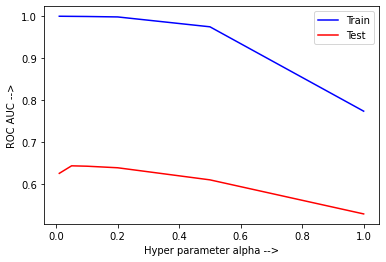

In [113]:
plotAucAllHyperParameter(gs.cv_results_)

# def plotAucAllHyperParameter(plot_data):
#     x = [ s['alpha'] for s in plot_data['params']]
#     y_test = plot_data['mean_test_score']
#     y_train = plot_data['mean_train_score']
#     plt.plot(x,y_train,label="Train",color='blue')
#     plt.plot(x,y_test,label="Test",color='red')
#     plt.xlabel("Hyper parameter alpha -->")
#     plt.ylabel("ROC AUC -->")
#     plt.legend()
#     plt.show()

In [125]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
bestmnb = MultinomialNB(alpha=0.05)
bestmnb.fit(train_set1,y_train)

MultinomialNB(alpha=0.05)

In [126]:
y_pred_test = bestmnb.predict_proba(test_set1)
y_pred_train = bestmnb.predict_proba(train_set1)

In [130]:
print(y_pred_test.shape)
y_pred_test

(21850, 2)


array([[4.78934339e-17, 1.00000000e+00],
       [9.16415454e-05, 9.99908358e-01],
       [1.86032134e-06, 9.99998140e-01],
       ...,
       [1.89009400e-59, 1.00000000e+00],
       [8.76392804e-14, 1.00000000e+00],
       [9.52006666e-42, 1.00000000e+00]])

In [129]:
print(y_pred_train.shape)
y_pred_train

(87398, 2)


array([[4.56570643e-89, 1.00000000e+00],
       [1.00000000e+00, 6.78352550e-42],
       [1.74389959e-62, 1.00000000e+00],
       ...,
       [1.00000000e+00, 1.51244339e-60],
       [1.62265523e-13, 1.00000000e+00],
       [2.23626012e-34, 1.00000000e+00]])

In [136]:
print(y_test.shape)
print(y_pred_test[:,1].shape)
print(y_test)
print(y_pred_test)

(21850,)
(21850,)
20582     1
102392    1
106502    0
86611     0
70789     1
         ..
46721     1
38674     1
86172     1
38956     1
76750     0
Name: project_is_approved, Length: 21850, dtype: int64
[[4.78934339e-17 1.00000000e+00]
 [9.16415454e-05 9.99908358e-01]
 [1.86032134e-06 9.99998140e-01]
 ...
 [1.89009400e-59 1.00000000e+00]
 [8.76392804e-14 1.00000000e+00]
 [9.52006666e-42 1.00000000e+00]]


In [132]:
test = roc_curve(y_test, y_pred_test[:,1])# this returns a list which is the order of [false_postive_rate,true_positive_rate,thresholds]
train = roc_curve(y_train,y_pred_train[:,1])
print("TEST AUC SCORE",roc_auc_score(y_test, y_pred_test[:,1]))

TEST AUC SCORE 0.6258898308842815


In [137]:
opt = [ (1-test[0][i])*(test[1][i]) for i in range(len(test[0]))]
optimal_theta = opt[opt.index(max(opt))]

In [139]:
print(opt)
print(optimal_theta)

[0.0, 0.3703177478575063, 0.36937205340677604, 0.362130103792599, 0.36185622314097987, 0.35843133735927074, 0.35837949257850116, 0.35528220711905145, 0.35517649593713, 0.35308349931271427, 0.3531579895024427, 0.3522064747414185, 0.3522558414068808, 0.3517449257654474, 0.3515358999999609, 0.3494966882597461, 0.3495453375760406, 0.34904488871110223, 0.3490691481556888, 0.34826565187410075, 0.34805480012891415, 0.34663563892399185, 0.34558123346754716, 0.3450911861655431, 0.34513885727842686, 0.3447636510568445, 0.34481122434938716, 0.34363010894447027, 0.3436066646693927, 0.34367768223701295, 0.3423977682876106, 0.34242132668641945, 0.34196902173268, 0.34173187261913446, 0.3412079794791184, 0.3409706999384514, 0.3404458938085855, 0.33977602011290553, 0.33979468749466063, 0.33981798503922656, 0.33855357561388455, 0.3385767753381095, 0.3380018851936132, 0.3377869902076621, 0.33773389006584875, 0.3377036309736763, 0.33734233154391674, 0.33721919203789374, 0.33714196287861525, 0.336903362763

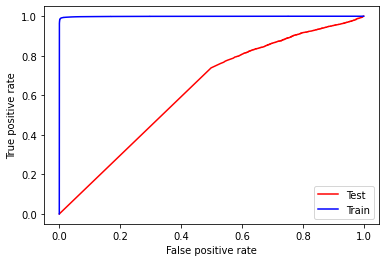

In [140]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
plt.plot(test[0],test[1],label="Test",color='red')
plt.plot(train[0],train[1],label="Train",color='blue')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

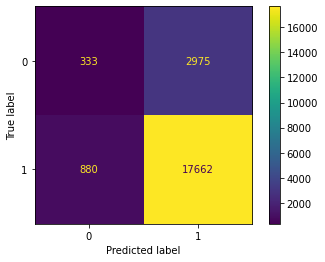

In [141]:
predicted = y_pred_test[:,1]
predicted[predicted>optimal_theta] = 1
predicted[predicted<= optimal_theta] = 0
matrix = confusion_matrix(y_test,predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

In [142]:
# def topKfretures_indices(model,class_,k):
#     max_index = np.argpartition(model.feature_log_prob_[class_], -k)[-k:]# Less the probality values the more negative the log value would be
#     return max_index
# def printTopKfeatur(model,class_,c):
#     indices = topKfretures_indices(model,class_,c)
#     featur_index = [train_bow.shape,train_state.shape,train_prefic.shape,train_grade.shape,
#                     trian_cat.shape,train_sub.shape,train_price.shape,train_prev_posted.shape]
#     mapp =  {0:'_wordE',1:'_state',2:'_prefic',3:'_grade',4:'_cat',5:'_sub',
#              6:'_price',7:'_prev_posted'}
#     models = {'_wordE':model_bow, '_state':model_state ,'_prefic':model_prefix ,
#               '_grade':model_grade ,'_cat':model_cat,'_sub':model_sub,
#              '_price':model_price,'_prev_posted':model_prev_posted}
    
#     index_mapp = {}
#     caps = []
#     summ = 0 
#     for i in range(len(featur_index)):
#         summ += featur_index[i][1]
#         index_mapp[summ]=mapp[i]
#         caps.append(summ)
#     #print(caps)
#     inv_mapp = list(index_mapp.keys())
#     count=0
#     for i in indices:
#         found = False
#         count+=1
#         for k in range(len(inv_mapp)-2):

#             if i<inv_mapp[k]:
#                 found = True
#                 #print(i,inv_mapp[k],index_mapp[inv_mapp[k]])
#                 class_num = k
#                 model_index = i# index in full vector space
#                 if class_num>0:
#                     model_index=model_index - caps[class_num-1]-1
#                 # print(model_index)
#                 # print(models[mapp[k]].vocabulary_.items())
#                 for i in models[mapp[k]].vocabulary_.items():
#                     if i[1]==model_index:
#                         print(count,". ",i[0])
#                         break
#                 break
#         if not found:
#             if i<caps[-2]:
#                 print(count,". ",'_price')
#             elif i < caps[-1]:
#                 print(count,". ",'_prev_posted')
# print("Top featurs that contributed to the Negative class: ")
# printTopKfeatur(bestmnb,0,20)
# print(20*"#"+"\n"+20*"#")
# print("Top featurs that contributed to the Positive class: ")
# printTopKfeatur(bestmnb,1,20)

Top featurs that contributed to the Negative class: 


NameError: ignored